# Preprocessing of Climate and Environment Data
This notebook loads raster data for climate and environmental data important to cropping production. Data is processed for an area of interest, and downscaled to a common spatial grid. Data are exported as a shape file and csv file. 

In [1]:
import pandas as pd
import geopandas as gpd 
from osgeo import gdal, ogr, osr, os
import numpy as np
from tobler.area_weighted import area_interpolate
import rioxarray as rxr
from shapely.geometry import mapping
from functools import reduce

import matplotlib.pyplot as plt

**Description of Raw Data**
1. Climate Data is obtained from the PRISM Climate Group.\
    a. 30-yr normals for the period of 1991-2020 \
    b. 800m resolution \
    c. Variables of mean annual temperature, mean total annual precipitation, and mean elevation which is used for a common grid reference \
    d. Data and metadata are availabe at https://prism.oregonstate.edu/normals/ 
2. Soil data is obtained from UC Davis compilation of SSURGO NRCS \
    a. SSURGO http://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/survey/?cid=nrcs142p2_053627 \
    b. 800m resolution \
    c. Variables of soil texture for 0-25 cm and 25 - 50 cm, plant available water content from 0-50 cm, and organic matter in kg/m2 \
    d. Data and metadata are available at https://casoilresource.lawr.ucdavis.edu/soil-properties/download.php
    
**Description of Processed Data**
1. Clip raster data to Kansas bounds (function clips to a rectangle, data will later be clipped to irregular bounds), set to common crs, and convert to vectorized shapefiles 
2. Read in all processed shapefiles and interpolate polygons to the finest polygon level (elevation)
3. Merge all files on geometry
4. Clip to irregular Kansas bounds 
5. Save processed data to a CSV and a shape file 

**Coding reference**
1. EarthLab tutorial for raster to vector data transformations https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/vector-data-processing/

**Read in each shapefile and clip to Kansas boundary**

In [2]:
# Kansas Shape file to clip data sources. Load data and select Kansas state boundaries  
fp= 'C:/Users/sarahann.USERS/Desktop/code/cb_2018_us_state_500k.shp' 

map_df = gpd.read_file(fp)
ks_map = map_df.NAME.isin(['Kansas']) 
ks_map = map_df[ks_map].loc[0:]
ks_map.to_crs(epsg=5070, inplace=True) 
ks_map.crs

<Derived Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
# File paths for PRISM data: precipitation, temperature and elevation
precip="C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/PRISM_ppt_30yr_normal_800mM3_annual_bil.bil"
temp="C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/PRISM_tmean_30yr_normal_800mM3_annual_bil.bil"
elv="C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/PRISM_us_dem_800m_bil.bil"
elv_4km="C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/PRISM_us_dem_4km_bil.bil"

# File path for soil data
paws_050 = "C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/paws_050.tif"
om_kg_sq_m = "C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/om_kg_sq_m.tif"
sand= "C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/sand.tif"
silt= "C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/silt.tif"
clay= "C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/clay.tif"

In [9]:
# Open all files, clip to Kansas Boundaries, and then save as a new tif 
# Note, this clip will clip to the farthest parameter edge. The final data, once interpolated will be clipped with geopandas to get the exact boundaries of Kansas. This is computationally expensive and is only done on the final output layer.

files = [precip, temp, elv, elv_4km, paws_050, om_kg_sq_m, sand, silt, clay]
files_str = ['precip', 'temp', 'elv', 'elv_4km','paws_050', 'om_kg_sq_m', 'sand', 'silt', 'clay']

for i,j in zip(files, files_str):
    x = rxr.open_rasterio(i).squeeze() # .squeeze removes a third dimension of 1 for band  and maintains a 2 dimension object
    x = x.rio.reproject(ks_map.crs)
    x=x.rio.clip(ks_map.geometry.apply(mapping),
                                          # This is needed if your df is in a diff CRS than the raster data, which is the case for the soil data in 5070
                                          ks_map.crs)
    x.rio.to_raster('C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/'+j+'_ks_clip.tif')

**Read each clipped shape tif (raster) and convert and save as a shape file (vector)**

In [10]:
# File paths for PRISM data: precipitation, temperature and elevation clipped to Kansas 
precip="C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/precip_ks_clip.tif"
temp="C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/temp_ks_clip.tif"
elv="C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/elv_ks_clip.tif"
elv_4km="C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/elv_4km_ks_clip.tif"

# File path for soil data clipped to Kansas 
paws_050 = "C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/paws_050_ks_clip.tif"
om_kg_sq_m = "C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/om_kg_sq_m_ks_clip.tif"
sand = "C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/sand_ks_clip.tif"
silt = "C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/silt_ks_clip.tif"
clay = "C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/clay_ks_clip.tif"

In [11]:
# Function to open each file, and save to a vector data format/shape file
def vec2rast (path, string):
    prism_ds = gdal.Open(path)                      
    band = prism_ds.GetRasterBand(1)
    dst_layername = string
    drv = ogr.GetDriverByName('ESRI Shapefile')

    # customer out path, and file name
    outfile = drv.CreateDataSource(r'C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/'+ string +'.shp') 
    outlayer = outfile.CreateLayer('polygonized raster', srs = None )  
    newField = ogr.FieldDefn(string, ogr.OFTReal)            #custom variable name
    outlayer.CreateField(newField)

    gdal.Polygonize(band, None, outlayer, 0, [])
    outfile = None

In [14]:
# Run Function for each raster and save as a shape file
vec2rast(elv,'elevation')
vec2rast(elv_4km,'elevation_4km')
vec2rast(temp,'temp')
vec2rast(precip,'precip')
vec2rast(paws_050,'paws_050') 
vec2rast(om_kg_sq_m, 'om_kg_sq_m')
vec2rast(sand, 'sand')
vec2rast(silt, 'silt')
vec2rast(clay, 'clay')

**Read each shape file (vector), and downscale to common geometry polygons**

In [15]:
# Function to open each file, read as a geopandas and set to commmon crs
variable_list = ['elevation', 'temp','precip','paws_050','om_kg_sq_m', 'sand', 'silt', 'clay',]

ks_variable = []

for string in variable_list:
    x = gpd.read_file('C:/Users/sarahann.USERS/Desktop/code/ks_agro_climate/'+string+'.shp')
    x.set_crs(epsg=5070, inplace=True) # using a metric unit and not a degree unit for geopandas calculations. #4328
    x.to_crs(epsg=5070)  
    x = x[x[string] >= -9000] # this drops all nan values which are set to -9999
    ks_variable.append(x) 

In [16]:
ks_variable[2].crs.to_epsg()

5070

In [17]:
# Determine the finest geometrical grid by printing geometry count for each geopandas 
for i in ks_variable:
    print(i.geometry.count())

256676
459
100208
49282
205321
215428
214277
182876


In [18]:
print('The Variables in order of the list are:')
for i in ks_variable:
    print([i.columns[0]])

The Variables in order of the list are:
['elevation']
['temp']
['precip']
['paws_050']
['om_kg_sq_m']
['sand']
['silt']
['clay']


**Interpolation with Tobler**
1. The variables of precipitation, temperature, PAWS, and organic matter are interpolated as extensive values, under the assumption that only areas for intersected features are utilized. 
2. The variables of texture for 0-25cm, and 25-50cm are calculated as categorical variables with final value selected on the high percent represented value in the polygon. 
3. Documentation for Tobler https://pysal.org/tobler/generated/tobler.area_weighted.area_interpolate.html#tobler.area_weighted.area_interpolate
4. A great explaination on interpolation methods is found here https://slu-opengis.github.io/areal/articles/areal-weighted-interpolation.html#extensive-and-intensive-interpolations-1

In [19]:
# Interpolate every variable to the same geometry as the elevation file (266147 unique polygons)
ks_variable_interp= []

for i in range(len(ks_variable)): # the first geo df is elevation and has the finest scale of geometries, so range count will start at 1 instead of 0 
    x = area_interpolate(source_df=ks_variable[i],target_df=ks_variable[0], intensive_variables=[ks_variable[i].columns[0]]) 
    ks_variable_interp.append(x)

In [20]:
# Look at the unique columns for the texture 
ks_variable_interp[4].columns.unique()

Index(['om_kg_sq_m', 'geometry'], dtype='object')

In [21]:
ks_variable[1].describe()

,temp
count,459.000000
mean,12.697168
std,1.043703
min,11.000000
25%,12.000000
50%,13.000000
75%,13.000000
max,15.000000


In [22]:
#Merge all files in the data frame
merge_df=reduce(lambda x, y: pd.merge(x, y, on = 'geometry'), ks_variable_interp)

In [23]:
merge_df.head()

,elevation,geometry,temp,precip,paws_050,om_kg_sq_m,sand,silt,clay
0,1048.0,"POLYGON ((-511701.775 1903862.765, -510950.491...",11.0,462.999959,10.999999,13.999999,15.999999,63.999996,20.999999
1,1059.0,"POLYGON ((-510950.491 1903862.765, -510199.207...",11.0,461.999980,10.200312,11.600936,36.791890,48.006241,15.402184
2,1028.0,"POLYGON ((-510199.207 1903862.765, -509447.923...",11.0,460.999980,9.952817,13.037917,41.436857,44.328141,13.974322
3,1035.0,"POLYGON ((-511701.775 1903111.481, -510950.491...",11.0,462.000000,11.000000,14.585402,12.487594,66.341609,21.585402
4,1025.0,"POLYGON ((-510950.491 1903111.481, -510199.207...",11.0,462.000000,9.419477,12.653916,36.736107,47.196245,16.109182


In [24]:
sum(merge_df.geometry == ks_variable_interp[0].geometry)

256676

<AxesSubplot:>

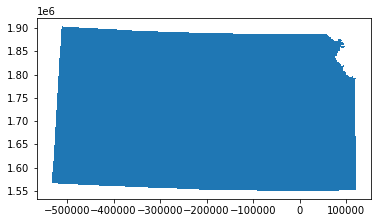

In [25]:
merge_df.plot()

<AxesSubplot:>

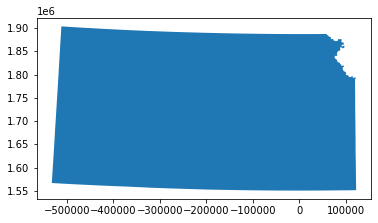

In [26]:
ks_map.plot()

In [27]:
merge_df.crs == ks_map.crs

True

In [28]:
ks_variables=gpd.overlay(merge_df, ks_map,  how='intersection')  

In [29]:
ks_variables=ks_variables.drop(columns=['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD','ALAND', 'AWATER'])
ks_variables=ks_variables.dropna() # three nan values for soil texture

In [30]:
print(ks_variables.describe())
ks_variables.head(5)

           elevation           temp         precip       paws_050  \
count  256676.000000  256676.000000  256676.000000  256676.000000   
mean      575.574635      12.635170     748.672351       8.727883   
std       248.823921       0.978884     201.850873       1.387318   
min       214.000000      10.999999     428.999973       0.000000   
25%       376.000000      12.000000     568.000032       7.971573   
50%       492.000000      13.000000     728.999999       8.995296   
75%       763.000000      13.000000     918.000026      10.000000   
max      1226.000000      15.000000    1207.000000      13.000000   

          om_kg_sq_m           sand           silt           clay  
count  256676.000000  256676.000000  256676.000000  256676.000000  
mean       20.262829      21.048089      50.037178      28.901962  
std         6.008277      18.323511      13.300847       8.887086  
min         0.000000       0.000000       0.000000       0.000000  
25%        17.039101       9.116569   

,elevation,temp,precip,paws_050,om_kg_sq_m,sand,silt,clay,geometry
0,1048.0,11.0,462.999959,10.999999,13.999999,15.999999,63.999996,20.999999,"POLYGON ((-510950.491 1903111.481, -511701.775..."
1,1059.0,11.0,461.999980,10.200312,11.600936,36.791890,48.006241,15.402184,"POLYGON ((-510199.207 1903111.481, -510950.491..."
2,1028.0,11.0,460.999980,9.952817,13.037917,41.436857,44.328141,13.974322,"POLYGON ((-509447.923 1902360.198, -510199.207..."
3,1035.0,11.0,462.000000,11.000000,14.585402,12.487594,66.341609,21.585402,"POLYGON ((-510950.491 1903111.481, -510950.491..."
4,1025.0,11.0,462.000000,9.419477,12.653916,36.736107,47.196245,16.109182,"POLYGON ((-510199.207 1903111.481, -510199.207..."


<AxesSubplot:>

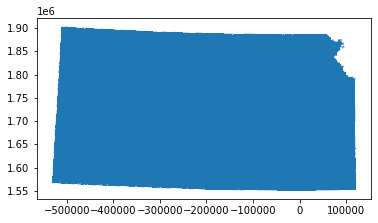

In [31]:
ks_variables.plot()

In [32]:
#Export Data as a CSV and shape files
ks_variables.to_csv('ks_variables.csv')
ks_variables.to_file('ks_variables.shape')